# Building a ReAct AI Agent from scratch with LangGraph

This demo will cover building AI Agents with LangGraph from scratch.

Here we'll create a simple ReAct agent app that can search the web and check the weather. The app consists of an agent (LLM) and tools. As we interact with the app, we will first call the agent (LLM) to decide if we should use tools. Then we will run a loop:

- If the agent said to take an action (i.e. call tool), we'll run the tools and pass the results back to the agent
- If the agent did not ask to run tools, we will finish (respond to the user)

We will implement this in LangGraph completely from scratch step by step.


There will be three parts to this hands-on demo:

- Part I: Build a Basic Chatbot with LangGraph
- Part II: Build a simple ReAct Agent with LangGraph - LLM + Tools
- Part III: Build a multi-user conversational ReAct Agent with LangGraph

## Install OpenAI, and LangChain dependencies

In [1]:
!pip install langchain==0.2.0
!pip install langchain-openai==0.1.7
!pip install langchain-community==0.2.0
!pip install langgraph==0.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.8/332.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.5/327.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 kB 3.3 MB/s eta 0:00:00


## Enter Open AI API Key

In [2]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key: ··········


## Enter Tavily Search API Key

Get a free API key from [here](https://tavily.com/#api)

In [3]:
TAVILY_API_KEY = getpass('Enter Tavily Search API Key: ')

Enter Tavily Search API Key: ··········


## Enter WeatherAPI API Key

Get a free API key from [here](https://www.weatherapi.com/signup.aspx)

In [4]:
WEATHER_API_KEY = getpass('Enter WeatherAPI API Key: ')

Enter WeatherAPI API Key: ··········


## Setup Environment Variables

In [5]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

## Part I: Build a Basic Chatbot with LangGraph

The first step will be to create a simple chatbot using LangGraph.

This chatbot will respond directly to user messages.

- We will start by creating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine"
- `nodes` will represent the llm and functions our chatbot can call
- `edges` will specify how the bot should transition between these functions



In [6]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    # Messages have the type "list"
    # The `add_messages` function in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

We've defined our `State` as a TypedDict with a single key: `messages`.

The `messages` key is annotated with the [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) function, which tells LangGraph to append new messages to the existing list, rather than overwriting it.

So now our graph knows two things:

1. Every `node` we define will receive the current `State` as input and return a value that updates that state.
2. `messages` will be _appended_ to the current list, rather than directly overwritten. This is communicated via the prebuilt [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) function in the `Annotated` syntax.

Next, we add a "`chatbot`" node.

Nodes represent units of work. They are typically regular python functions.

This is a simple node which will just send our messages to an LLM.

In [7]:
from langchain_openai import ChatOpenAI

chatgpt = ChatOpenAI(model="gpt-4o", temperature=0)


def chatbot(state: State):
    return {"messages": [chatgpt.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object
# this function will be called whenever the node is used.
graph_builder.add_node("chatbot", chatbot)

The `chatbot` node function takes the current `State` as input and returns an updated `messages` list.

This is the basic pattern for all LangGraph node functions.

The `add_messages` function in our `State` will append the LLM's response messages to whatever messages are already in the state.

Next, we add an `entry` point. This tells our graph **where to start its work** each time we run it.

In [8]:
graph_builder.set_entry_point("chatbot")

Similarly, we set a `finish` point. This instructs the graph **"any time this node is run, you can exit."**

In [9]:
graph_builder.set_finish_point("chatbot")

Now we will compile our graph by calling "`compile()`" on the graph builder.

This creates a "`CompiledGraph`" we can use invoke on our state.

In [10]:
graph = graph_builder.compile()

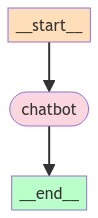

In [11]:
from IPython.display import Image, display, Markdown

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
prompt = """What is the fastest animal on land?"""
response = graph.invoke({"messages": ("user", prompt)})

In [13]:
response

{'messages': [HumanMessage(content='What is the fastest animal on land?', id='0fd69be9-e68b-4f18-a28a-6816514f3628'),
  AIMessage(content='The fastest animal on land is the cheetah (Acinonyx jubatus). Cheetahs can reach speeds of up to 60 to 70 miles per hour (97 to 113 kilometers per hour) in short bursts covering distances up to 500 meters (1,640 feet). They are specially adapted for speed with a lightweight frame, long legs, and a flexible spine that allows for an extended stride.', response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 15, 'total_tokens': 100}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_d576307f90', 'finish_reason': 'stop', 'logprobs': None}, id='run-1a68bf00-4d05-4de1-b0b2-8faeefe38220-0')]}

In [17]:
prompt = """What is langraph?"""
response = graph.invoke({"messages": ("user", prompt)})
display(Markdown(response['messages'][-1].content))

As of my last update in October 2023, there is no widely recognized technology, software, or concept known as "langraph." It's possible that it could be a new or niche term that has emerged recently, or it might be a misspelling or a combination of other terms.

If "langraph" is a new term or a specific product, service, or concept that has been introduced after my last update, I wouldn't have information on it. In that case, I recommend checking the latest sources or providing more context so I can assist you better.

In [18]:
response

{'messages': [HumanMessage(content='What is langraph?', id='4a2def9f-46d5-4808-81c5-5b3414396a2b'),
  AIMessage(content='As of my last update in October 2023, there is no widely recognized technology, software, or concept known as "langraph." It\'s possible that it could be a new or niche term that has emerged recently, or it might be a misspelling or a combination of other terms.\n\nIf "langraph" is a new term or a specific product, service, or concept that has been introduced after my last update, I wouldn\'t have information on it. In that case, I recommend checking the latest sources or providing more context so I can assist you better.', response_metadata={'token_usage': {'completion_tokens': 114, 'prompt_tokens': 12, 'total_tokens': 126}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_d576307f90', 'finish_reason': 'stop', 'logprobs': None}, id='run-aa03babb-1a9d-405e-a298-10f2cd91386f-0')]}

We have built a simple chatbot using LangGraph.

This bot can engage in basic conversation by taking user input and generating responses using an LLM. However it cannot give responses to recent information, here we will enhance it with some tools

## Part II: Build a simple ReAct Agent with LangGraph - LLM + Tools

Now, we will build a simple ReAct agent in LangGraph which will use the web search or weather tool based on our input prompts to get relevant data which the LLM might not know by default and give relevant responses

We will showcase the following:

1. Building the agent completely from scratch
2. Leveraging LangGraph built-in node functions to build the agent faster

### Create Tools

Here we create two custom tools which are wrappers on top of the [Tavily API](https://tavily.com/#api) and [WeatherAPI](https://www.weatherapi.com/)

- Simple Web Search tool
- Weather tool

In [19]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
import json
import requests

tv_search = TavilySearchResults(max_results=3, search_depth='advanced',
                                max_tokens=10000)

@tool
def search_web(query: str) -> list:
    """Search the web for a query."""
    results = tv_search.invoke(query)
    return results

@tool
def get_weather(query: str) -> list:
    """Search weatherapi to get the current weather."""
    base_url = "http://api.weatherapi.com/v1/current.json"
    complete_url = f"{base_url}?key={WEATHER_API_KEY}&q={query}"

    response = requests.get(complete_url)
    data = response.json()
    if data.get("location"):
        return data
    else:
        return "Weather Data Not Found"


### Build the Agentic Graph from Scratch

Here we will use LangGraph to build the full graph which will have the Agentic workflow.

Each functionality will be implemented from scrach

In [20]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o", temperature=0)
# Tell the LLM which tools it can call
tools = [search_web, get_weather]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

We will now need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

We implement a `BasicToolNode` that checks the most recent message in the state and calls tools if the message contains `tool_calls`.

It relies on the LLM's `tool_calling` support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

We will later replace this with LangGraph's prebuilt [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) to speed things up, but building it from scratch gives us an idea of what happens under the hood

In [21]:
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools} # => {'search_web': search_web, 'get_weather': get_weather}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1] # get most recent message
        else:
            raise ValueError("No message found in input")
        outputs = []
        # if tool calls are mentioned by LLM in the most recent message
        # call the tool and get the result
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}
# add tool node to graph
tool_node = BasicToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

With the tool node added, we can define the `conditional_edges`.

Remember that **edges** route the control flow from one node to the next.

**Conditional edges** usually contain "if" statements to route to different nodes depending on the current graph state.

These functions receive the current graph `state` and return a string or list of strings indicating which node(s) to call next.

Below, we will define a router function called `route_tools`, that checks for `tool_calls` in the chatbot's output.

We provide this function to the graph by calling `add_conditional_edges`, which tells the graph that whenever the `chatbot` node completes to check this function to see where to go next.

The condition will route to `tools` if tool calls are present and "`__end__`" if not.

Later, we will replace this with the prebuilt [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition) to be more concise, here we implement it from scratch to see what happens under the hood

In [22]:
from typing import Literal

def route_tools( state: State,) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    # if state is a list of messages get the last one
    if isinstance(state, list):
        ai_message = state[-1]
    # if state is a dict, try to get the last message from the messages key
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    # if the last message is refering to a tool call, route to the tools node
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    # else route to end (stop the agent)
    return "__end__"

# The `tools_condition` function returns "tools"
# if the chatbot asks to use a tool,
# and "__end__" if it is fine directly responding and stopping the agent.
# This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
# set the entry point
graph_builder.set_entry_point("chatbot")
# compile the graph
graph = graph_builder.compile()

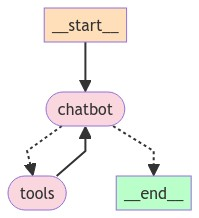

In [23]:
from IPython.display import Image, display, Markdown

display(Image(graph.get_graph().draw_mermaid_png()))

Let's test out our agent now

In [24]:
prompt = """What is the fastest animal on land?"""
response = graph.invoke({"messages": ("user", prompt)})
display(Markdown(response['messages'][-1].content))

The fastest animal on land is the cheetah. Cheetahs can reach speeds of up to 60 to 70 miles per hour (97 to 113 kilometers per hour) in short bursts covering distances up to 500 meters (1,640 feet), and they can accelerate from 0 to 60 miles per hour in just a few seconds.

In [25]:
response

{'messages': [HumanMessage(content='What is the fastest animal on land?', id='fd360c27-784e-4593-964c-1438de91626d'),
  AIMessage(content='The fastest animal on land is the cheetah. Cheetahs can reach speeds of up to 60 to 70 miles per hour (97 to 113 kilometers per hour) in short bursts covering distances up to 500 meters (1,640 feet), and they can accelerate from 0 to 60 miles per hour in just a few seconds.', response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 75, 'total_tokens': 148}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_4008e3b719', 'finish_reason': 'stop', 'logprobs': None}, id='run-9e47b043-a56c-4772-9d9d-ee8c7cccf6d4-0')]}

In [26]:
prompt = """What is langraph?"""
response = graph.invoke({"messages": ("user", prompt)})
display(Markdown(response['messages'][-1].content))

LangGraph is a library designed for building stateful, multi-actor applications with Large Language Models (LLMs). It is used to create agent and multi-agent workflows. Here are some of its key features and benefits:

1. **Cycles**: LangGraph allows the definition of flows that involve cycles, which are essential for most agentic architectures.
2. **Controllability**: It offers a high degree of control over the workflows.
3. **Persistence**: It supports the persistence of states across different sessions.

LangGraph is integrated into the LangChain ecosystem, allowing users to take full advantage of LangChain integrations and observability features. It is available in both Python and JavaScript, enabling the creation of graphs with nodes, edges, state, tools, and conditional edges for agentic behaviors.

In [27]:
response

{'messages': [HumanMessage(content='What is langraph?', id='396ab7f9-ad8e-472b-8318-b036d1e267a0'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_lly3TrpPVGD7N3hdDEa7I1xa', 'function': {'arguments': '{"query":"langraph"}', 'name': 'search_web'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 72, 'total_tokens': 87}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_ce0793330f', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-43e6491b-2f81-44b8-8790-807ccd558c1e-0', tool_calls=[{'name': 'search_web', 'args': {'query': 'langraph'}, 'id': 'call_lly3TrpPVGD7N3hdDEa7I1xa'}]),
  ToolMessage(content='[{"url": "https://langchain-ai.github.io/langgraph/", "content": "Overview. LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Compared to other LLM frameworks, it offers these core benefits: cycles, controllability, and persistence

### Build the Agentic Graph with LangGraph built-ins - Recommended Flow

Here we will use LangGraph to build the full graph which will have the Agentic workflow.

Each functionality will be implemented as we would in the real-world.

Here we will be replacing our `BasicToolNode` for the prebuilt [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode),
and our `route_tools` condition with the prebuilt [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition)

In [28]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

# define function which will be used to store all agent messages
class State(TypedDict):
    messages: Annotated[list, add_messages]

# start the graph building
graph_builder = StateGraph(State)

# add tools and bind to LLM
tools = [search_web, get_weather]
llm = ChatOpenAI(model="gpt-4o", temperature=0)
llm_with_tools = llm.bind_tools(tools)

# add the LLM to graph
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

# Add tools to a node
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# add conditional edges
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {'tools': 'tools', '__end__': '__end__'}
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
# Define entry point to the graph
graph_builder.set_entry_point("chatbot")
# compile the graph
graph = graph_builder.compile()

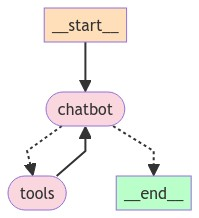

In [29]:
from IPython.display import Image, display, Markdown

display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
prompt = """What is the weather in bangalore?
show detailed statistics"""
response = graph.invoke({"messages": ("user", prompt)})
display(Markdown(response['messages'][-1].content))

### Current Weather in Bangalore, Karnataka, India

- **Temperature**: 24.3°C (75.7°F)
- **Condition**: Partly cloudy ![Partly cloudy](//cdn.weatherapi.com/weather/64x64/day/116.png)
- **Feels Like**: 25.9°C (78.7°F)
- **Wind**: 19.1 kph (11.9 mph) from the WSW (240°)
- **Pressure**: 1015.0 mb (29.97 in)
- **Precipitation**: 0.0 mm (0.0 in)
- **Humidity**: 83%
- **Cloud Cover**: 75%
- **Visibility**: 6.0 km (3.0 miles)
- **UV Index**: 6.0 (Moderate)
- **Gusts**: 24.8 kph (15.4 mph)
- **Dew Point**: 18.2°C (64.7°F)

#### Location Details
- **Latitude**: 12.98
- **Longitude**: 77.58
- **Local Time**: 2024-06-30 09:07 AM (Asia/Kolkata)

This data was last updated at 09:00 AM on June 30, 2024.

In [31]:
prompt = """What is the weather in dubai? show detailed statistics"""
response = graph.invoke({"messages": ("user", prompt)})
display(Markdown(response['messages'][-1].content))

The current weather in Dubai is as follows:

- **Location**: Dubai, United Arab Emirates
- **Local Time**: 2024-06-30 07:37

### Current Conditions:
- **Temperature**: 34.2°C (93.6°F)
- **Feels Like**: 38.6°C (101.5°F)
- **Condition**: Sunny ![Sunny](//cdn.weatherapi.com/weather/64x64/day/113.png)
- **Wind**: 6.8 kph (4.3 mph) from the SSE (160°)
- **Pressure**: 996.0 mb (29.41 in)
- **Precipitation**: 0.0 mm (0.0 in)
- **Humidity**: 53%
- **Cloud Cover**: 0%
- **Visibility**: 10.0 km (6.0 miles)
- **UV Index**: 8.0
- **Wind Gusts**: 13.9 kph (8.7 mph)

### Additional Information:
- **Dew Point**: 21.6°C (70.8°F)
- **Heat Index**: 38.9°C (101.9°F)

It is a sunny day with clear skies and moderate humidity.

In [32]:
prompt = """Which city is hotter?"""
response = graph.invoke({"messages": ("user", prompt)})
display(Markdown(response['messages'][-1].content))

Sure, I can help with that. Please provide the names of the cities you want to compare.

We have successfully built an AI Agent which can search the web, get weather for us but it is not yet conversational. We will add in the that functionality in Part III next.

## Part III: Build a multi-user conversational ReAct Agent with LangGraph

Now, we will build a multi-user conversational ReAct agent with LangGraph which will use the web search or weather tool based on our input prompts to get relevant data which the LLM might not know by default and give relevant responses

Our agentic chatbot from Part II can use tools to answer user questions, but it doesn't remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.

LangGraph solves this problem through **persistent checkpointing**. If you provide a `checkpointer` when compiling the graph and a `thread_id` when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same `thread_id`, the graph loads its saved state, allowing the chatbot to pick up where it left off.

**checkpointing** is _much_ more powerful than simple chat memory - it lets you save and resume complex state at any time for error recovery, human-in-the-loop workflows, time travel interactions, and more

While the legacy syntax uses `session_id`, in LangGraph, each user session is identified by `thread_id`

We will use `SqliteSaver` which helps to store separate conversation histories per user or session.

This will help us build a conversational Agentic Chatbot which will be accessed by many users at the same time.



In [33]:
# removes the memory database file - usually not needed
# you can run this only when you want to remove ALL conversation histories
# ok if you get rm: cannot remove 'memory.db': No such file or directory  because initially no memory exists
!rm memory.db*

rm: cannot remove 'memory.db*': No such file or directory


In [34]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.sqlite import SqliteSaver

# used to retrieve conversation history from database
# based on a specific user or session ID  - thread_id
memory = SqliteSaver.from_conn_string("memory.db")

# define function which will be used to store all agent messages
class State(TypedDict):
    messages: Annotated[list, add_messages]

# start the graph building
graph_builder = StateGraph(State)

# add tools and bind to LLM
tools = [search_web, get_weather]
llm = ChatOpenAI(model="gpt-4o", temperature=0)
llm_with_tools = llm.bind_tools(tools)

# add the LLM to graph
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

# Add tools to a node
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# add conditional edges
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    # either goes to tool node if tool calls or else end node
    {'tools': 'tools', '__end__': '__end__'}
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
# Define entry point to the graph
graph_builder.set_entry_point("chatbot")
# compile the graph - Add the memory here
graph = graph_builder.compile(checkpointer=memory)

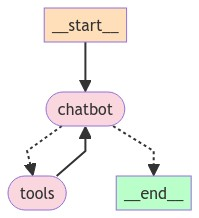

In [35]:
from IPython.display import Image, display, Markdown

display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
def chat_with_agent(prompt: str, session_id: str):
    response = graph.invoke({"messages": [('user', prompt)]},
                                      {'configurable': { 'thread_id': session_id}})
    display(Markdown(response['messages'][-1].content))

Let's now simulate User 1 using the agent

In [37]:
user_id = 'jack001'
prompt = "Tell me about langraph"
chat_with_agent(prompt, user_id)

LangGraph is a library designed for building stateful, multi-actor applications with Large Language Models (LLMs). It is particularly useful for creating agent and multi-agent workflows. Here are some key features and benefits of LangGraph:

1. **Cycles**: LangGraph allows you to define workflows that involve cycles, which are essential for most agentic architectures.
2. **Controllability**: It provides mechanisms to control the flow and behavior of agents within the workflow.
3. **Persistence**: The library supports the persistence of state, which is crucial for maintaining the context and continuity of interactions.

LangGraph is available in both Python and JavaScript, making it versatile for different development environments. It is fully integrated into the LangChain ecosystem, allowing users to take advantage of LangChain's integrations and observability features.

For more detailed information, you can visit the [LangGraph documentation](https://langchain-ai.github.io/langgraph/) or check out its [GitHub repository](https://github.com/langchain-ai/langgraph).

In [38]:
prompt = "What is it used for?"
chat_with_agent(prompt, user_id)

LangGraph is used for building stateful, multi-actor applications with Large Language Models (LLMs). Here are some specific use cases and applications:

1. **Agent and Multi-Agent Workflows**: LangGraph is designed to create workflows involving multiple agents. These agents can interact with each other and perform tasks in a coordinated manner.

2. **Stateful Applications**: It allows for the creation of applications that maintain state across interactions. This is crucial for applications that require context and continuity, such as conversational agents or complex decision-making systems.

3. **Conditional Flows**: LangGraph supports the definition of conditional edges and nodes, enabling the creation of dynamic and adaptable workflows. This is useful for applications that need to respond to changing conditions or inputs.

4. **Integration with LangChain**: Being fully integrated into the LangChain ecosystem, LangGraph can leverage LangChain's tools and observability features. This makes it easier to build, monitor, and manage complex LLM-based applications.

5. **Message Passing and Chat Models**: LangGraph can be used to create applications that involve message passing between agents, which is essential for chat models and other communication-based systems.

6. **Agentic Behaviors**: The library allows for the implementation of agentic behaviors, where agents can make decisions, take actions, and interact with their environment in a controlled manner.

In summary, LangGraph is a powerful tool for developers looking to build sophisticated, stateful applications that involve multiple interacting agents, particularly in the context of LLMs.

Let's now simulate User 2 using the agent

In [39]:
user_id = 'bond007'
prompt = "how is the weather in Bangalore today? Show detailed statistics"
chat_with_agent(prompt, user_id)

The weather in Bangalore today is as follows:

- **Condition**: Partly cloudy ![Partly cloudy](//cdn.weatherapi.com/weather/64x64/day/116.png)
- **Temperature**: 24.2°C (75.6°F)
- **Feels Like**: 25.8°C (78.5°F)
- **Wind**: 20.2 kph (12.5 mph) from the WSW (250°)
- **Gusts**: Up to 24.8 kph (15.4 mph)
- **Humidity**: 83%
- **Pressure**: 1015.0 mb (29.97 in)
- **Precipitation**: 0.0 mm (0.0 in)
- **Cloud Cover**: 75%
- **Visibility**: 8.0 km (4.0 miles)
- **UV Index**: 6 (Moderate)
- **Dew Point**: 18.2°C (64.7°F)

The data was last updated at 09:45 AM local time.

In [40]:
user_id = 'bond007'
prompt = "what about Dubai?"
chat_with_agent(prompt, user_id)

The weather in Dubai today is as follows:

- **Condition**: Sunny ![Sunny](//cdn.weatherapi.com/weather/64x64/day/113.png)
- **Temperature**: 35.4°C (95.7°F)
- **Feels Like**: 41.1°C (105.9°F)
- **Wind**: 6.8 kph (4.3 mph) from the SSW (200°)
- **Gusts**: Up to 14.0 kph (8.7 mph)
- **Humidity**: 44%
- **Pressure**: 997.0 mb (29.44 in)
- **Precipitation**: 0.0 mm (0.0 in)
- **Cloud Cover**: 0%
- **Visibility**: 10.0 km (6.0 miles)
- **UV Index**: 8 (Very High)
- **Dew Point**: 22.4°C (72.2°F)

The data was last updated at 08:15 AM local time.

In [41]:
user_id = 'bond007'
prompt = "which city is hotter?"
chat_with_agent(prompt, user_id)

Currently, Dubai is hotter than Bangalore.

- **Dubai**: 35.4°C (95.7°F)
- **Bangalore**: 24.2°C (75.6°F)

Dubai's temperature is significantly higher than Bangalore's.